In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm

import sktime
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

from sklearn.metrics import mean_squared_error

from prophet import Prophet

import missingno as msno
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Understanding basic concepts in Time Series



## From White Noise to ACF plots

In [ ]:
np.random.seed(1234)
# generate white noise for 200 observations and plot it
white_noise = np.random.normal(0, 1, 200)
plt.plot(white_noise)


In [ ]:
# generate a white noise with mean 4 and sd 2 then use the arima function to estimate the parameters
white_noise = np.random.normal(4, 2, 200)
ARIMA(white_noise, order=(1, 0, 0)).fit().summary()

### Explain with your own words what a random walk is (minimum 100 words).

A random walk is a time series where the next value is dependent on the previous value. A white noise is a time series where the next value is independent of the previous value. 

### Explain with your own words what stationarity means for a time series

A stationary time series is a time series where the mean, variance and autocorrelation are constant over time.

In [ ]:
# Create a random walk series, plot it, calculate the first difference series and plot it
random_walk = np.cumsum(np.random.normal(0, 1, 200))
plt.plot(random_walk)
plt.plot(np.diff(random_walk))
plt.show()

In [ ]:
# Generate WN drift data, convert it to a random walk and plot it
white_noise_drift = np.cumsum(np.random.normal(0, 1, 200)) + (np.arange(200) / 10)
plt.plot(white_noise_drift)
plt.show()

In [ ]:
# Plot the ACF on the white noise.
plot_acf(white_noise, lags=20)
plt.show()

### What’s the characteristic of a white noise ACF ?

The ACF of a white noise is 0 for all lags. Moreover, they are never statistically significant.

In [ ]:
# Perform a Ljung-Box Test. Command : Box.test in R, ljung is an option.
acorr_ljungbox(white_noise, lags=20)

## ARMA models

In [ ]:
# Use the arima.sim function (or Python equivalent) to generate time series based on the autoregressive model, with slopes comprised between -1 and 1.
arima_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)
plt.show()

### What do you observe ?

The ACF of the random walk is not 0 for all lags. Moreover, they are statistically significant. also, the lags are positively correlated.

In [ ]:
# Plot them, and the acf functions along with it.
plot_acf(arima_sim, lags=20).show()

In [ ]:
# Do the same with the moving average model. What do you observe ?
arima_sim = ArmaProcess(ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)

In [ ]:
plot_acf(arima_sim, lags=20).show()

### What do you observe ?

The ACF of the MA simulation is not 0 for all lags. Moreover, they are statistically significant. also, the lags are negatively correlated.

In [ ]:
# Contrast AR(1) and AR(2) models. How do they differ ?

# AR(1)
arima_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)


# AR(2)
arima_sim = ArmaProcess(ar = [0.3, -0.25, 0.3]).generate_sample(nsample=200)
plt.plot(arima_sim)

plt.legend(['AR(1)', 'AR(2)'])
plt.show()


They differ by how the lags are correlated. The AR(2) model is more correlated to its 2 previous lags rather than the AR(1) model which is more correlated to only its first lag.

### What is the difference between an Autocorrelation Function and a Partial autocorrelation Function ? (Min. 150 words)

The ACF is the correlation between the time series and its lags. The PACF is the correlation between the time series and its lags, while controlling for the effect of the intermediate lags. The PACF is a better indicator of the order of the AR model. The PACF of an AR(1) model is 0 for all lags after the first lag. The PACF of an AR(2) model is 0 for all lags after the second lag.


In [ ]:
# Plot the ACF and the PACF of an AR, a MA, and ARMA models.
ar_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)

ma_sim = ArmaProcess(ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(ma_sim)

arma_sim = ArmaProcess(ar = [0.3, -0.25], ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arma_sim)

plt.legend(['AR', 'MA', 'ARMA'])
plt.show()

# Plot the ACF and the PACF of an AR, a MA, and ARMA models.
plot_acf(ar_sim, lags=20).show()
plot_acf(ma_sim, lags=20).show()
plot_acf(arma_sim, lags=20).show()


The main difference between the ACF and the PACF is that the PACF is a better indicator of the order of the AR model. The PACF of an AR(1) model is 0 for all lags after the first lag. The PACF of an AR(2) model is 0 for all lags after the second lag.

### Write the equation of an ARMA model

$$X_t = \mu + \epsilon_t + \sum_{i=1}^p \phi_i X_{t-i} + \sum_{i=1}^q \theta_i \epsilon_{t-i}$$

### What are the main differences between AIC and BIC criteria, conceptually speaking ? Elaborate (Min. 100 words).

The AIC criterion is the log-likelihood of the model plus a penalty term. The BIC criterion is the log-likelihood of the model plus a penalty term. The penalty term is higher for the BIC criterion. The AIC criterion is more suitable for small sample sizes, while the BIC criterion is more suitable for large sample sizes.


# Forecasting competition on Kaggle


In [ ]:
# Read the kaggle dataset
sales_train = pd.read_csv('Kaggle dataset/sales_train.csv')
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")

sales_train

In [ ]:
# Choose item #20949 in sales_train
sales_train_item20949 = sales_train[sales_train["item_id"] == 20949]
sales_train_item20949

In [ ]:
# Create a time series of the Kaggle dataset, but with a lag 1
sales_train_item20949_lag1 = sales_train_item20949.shift(1)
sales_train_item20949_lag1

In [ ]:
# cbind the two datasets, and look at them using the head command
to_merge = sales_train_item20949_lag1.iloc[1: , :].append([None])
merged_with_lag = pd.concat([sales_train_item20949, to_merge], axis=1).iloc[:-1, :].drop(0, axis=1)
merged_with_lag

In [ ]:
# use the cor function to look at the datasets, and then the acf function, with a lag 1.
# Plot the acf with different logs to see what happens.
sns.heatmap(sales_train_item20949.corr(), annot=True)
sales_train_item20949["item_cnt_day"].plot()
plt.show()
plot_acf(sales_train_item20949["item_cnt_day"]).show()

In [ ]:
# Set index to date
sales_train_item20949 = sales_train_item20949.set_index("date")

In [ ]:
# Fit and plot an auto-regressive model to the time series.
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()
plt.show()

What are the intercept and the innovation variance (sigma2) estimate ?
What do these parameters mean ?

The intercept is the mean of the time series and the innovation variance is the variance of the error term.

In [ ]:
# Predict the sales for a month after the end of the training dataset.
# Use the predict function, and the forecast function.
# Plot the results.
X = sales_train_item20949["item_cnt_day"].values
ARIMA_model = ARIMA(X, order=(3, 0, 0))
ARIMA_model_fit = ARIMA_model.fit()
predictions = ARIMA_model_fit.forecast(steps=700)

plt.plot(predictions, color='red')
plt.show()

In [ ]:
# Fit and plot a moving average model, and print the estimates
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(0, 0, 1))
model_fit = model.fit()
model_fit.summary()

In [ ]:
# Make a 1 to 15 steps forecast, and plot the 95 percent confidence intervals
X = sales_train_item20949["item_cnt_day"].values
ARIMA_model = ARIMA(X, order=(0, 0, 1))
ARIMA_model_fit = ARIMA_model.fit()
predictions = ARIMA_model_fit.get_forecast(steps=15)
confidence_interval = pd.DataFrame(predictions.conf_int(alpha = 0.05))

plt.plot(predictions.predicted_mean, color='red')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='red', alpha=.25)
plt.show()

In [ ]:
# Compare the goodness of fit of AR and MA models through AIC and BIC criteria

# AR(1)
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

# MA(1)
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

The best model in this case according to AIC and BIC is the AR model, because lower is better.

In [ ]:
plot_acf(sales_train_item20949["item_cnt_day"], lags=20).show()

In [ ]:
# Use the residual analysis graphics of the Sarima function to check whether there are patterns in the residuals

# Fit a SARIMA model
model = SARIMAX(sales_train_item20949["item_cnt_day"], order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit()
model_fit.plot_diagnostics()

Do you see any patterns in the residuals for the diverse models you have implemented ?
No, the residuals are white noise.

How should Q-Q plot look like when the model is a good fit ?
The points of the Q-Q plot should all follow the line, in this case, the points follow the line quite well.

In [ ]:
# Fit various models (ARMA(1,1) - ARMA(2,1) - ARIMA(1,1,1) - ARIMA(1,1,0) to the Kaggle time series, and plot the t-table, check diagnostics

# ARMA(1,1)
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()

# ARMA(2,1)
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(2, 0, 1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()

# ARIMA(1,1,1)
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()

# ARIMA(1,1,0)
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()

In [ ]:
# Fit a seasonal model to the Kaggle dataset. Fit ACF models with the relevant lags. Example : SARIMA(2,1,0,1,0,0,12). What are the conceptual differences between an ARIMA and a SARIMA, from the mathematical point of view ? Then, play with the parameters of the seasonnal component of the model (increase them), and see how forecasting is affected.

# SARIMA(2,1,0,1,0,0,12)
model = SARIMAX(sales_train_item20949["item_cnt_day"], order=(2, 1, 0), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()

The difference between ARIMA and SARIMA is that the ARIMA model is a linear model, while the SARIMA model is a non-linear model. The SARIMA model is a linear model with a seasonal component.

In [ ]:
# Present a relevant sample of Ljung-Box tests, and explain how they can be used to assess your models

acorr_ljungbox(model_fit.resid, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], boxpierce=True)

The Ljung-Box test is a test for autocorrelation. The null hypothesis is that the residuals are white noise. The p-value is the probability of rejecting the null hypothesis. If the p-value is lower than 0.05, we reject the null hypothesis and conclude that the residuals are not white noise.

In [ ]:
# Use your favourite model to forecast the time series on the available test datasets

# Fit a SARIMA model
model = SARIMAX(sales_train_item20949["item_cnt_day"], order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit()
model_fit.plot_diagnostics()

# Make predictions and plot them using model_fit
predictions = model_fit.get_forecast(steps=700)
sarimax_predictions = predictions.predicted_mean
confidence_interval = pd.DataFrame(predictions.conf_int(alpha = 0.05))

plt.plot(predictions.predicted_mean, color='red')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='red', alpha=.25)
plt.show()


In [ ]:
# Perform a naive forecast based on the forecast package, to predict the sales for the training datasets

# Fit a naive model
naive_model = NaiveForecaster()
naive_model.fit(y = sales_train_item20949["item_cnt_day"], X = sales_train_item20949["date"])

# Make predictions and plot them using model_fit
predictions = naive_model.predict(fh=list(range(30)))
naive_predictions = predictions

plt.plot(sales_train_item20949["item_cnt_day"][-30:], color='blue')
plt.plot(predictions, color='red')
plt.show()

#### 21: Remind us to what correspond the two shades of blue in the confidence intervals

The two shades of blue correspond to the 95% confidence interval.

#### 22: Use the accuracy command to compute the RMSE statistics of your favourite models. What does RMSE mean ? What is the difference with MAE ? Why is it usually preferred to MSE ?

In [ ]:
sarimax_predictions[-30:]

In [ ]:
# Compute the accuracy of the naive model, and compare it to the accuracy of the SARIMA model

# Compute the accuracy of the naive model

print("Naive model accuracy : ", mean_squared_error(sales_train_item20949["item_cnt_day"][-30:], naive_predictions))

# Compute the accuracy of the SARIMA model

print("SARIMA model accuracy : ", mean_squared_error(sales_train_item20949["item_cnt_day"][-30:], sarimax_predictions[-30:]))

From this we can conclude that a simple forecasting method is better than a more complex one on the last month.

RMSE is the root mean squared error. It is the square root of the mean of the squared errors. The difference with MAE is that the RMSE is more sensitive to outliers. It is usually preferred to MSE because it is easier to interpret.

#### 23: Write a command that only returns the mean absolute percentage error

In [ ]:
# Write a command that only returns the mean absolute percentage error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### 24: Compute cross-validated errors for up to a week ahead, with a naive forecast approach

In [ ]:
# Compute cross-validated errors for up to a week ahead, with a naive forecast approach



#### 25: Use Auto-ARIMA to fit a model to your data. How does Auto-ARIMA work ?

In [ ]:
sales_datetime = sales_train_item20949.groupby("date").sum().reset_index()
sales_datetime = sales_datetime[["date", "item_cnt_day"]]
sales_datetime = sales_datetime.set_index("date")
sales_datetime = sales_datetime.asfreq('D')
sales_datetime = sales_datetime.fillna(0)
sales_datetime["item_cnt_day"] = sales_datetime["item_cnt_day"].astype(int)
sales_datetime

In [ ]:
# Use Auto-ARIMA to fit a model to your data. How does Auto-ARIMA work ?

# Fit an auto-ARIMA model
auto_arima_model = AutoARIMA(seasonal=True)
auto_arima_model.fit(sales_datetime["item_cnt_day"])

# Make predictions and plot them using model_fit
predictions = auto_arima_model.predict(fh=list(range(30)))
auto_arima_predictions = predictions

plt.plot(predictions, color='red')
plt.show()

Auto-arima works by trying different combinations of parameters and choosing the one that minimizes the AIC criterion.

# Forecasting with Prophet

In [3]:
# import crimes data

crimes = pd.read_csv("crimes.csv")
crimes

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7650194,12748153,JF301761,07/01/2022 05:29:00 PM,044XX N KASSON AVE,1811,NARCOTICS,POSSESS - CANNABIS 30 GRAMS OR LESS,STREET,True,False,...,39.0,14.0,18,1148374.0,1929416.0,2022,10/11/2022 04:45:59 PM,41.962262,-87.729878,"(41.962261812, -87.729878215)"
7650195,12742026,JF294494,06/24/2022 03:43:00 PM,075XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,False,False,...,49.0,1.0,06,1162907.0,1949949.0,2022,10/11/2022 04:45:59 PM,42.018312,-87.675867,"(42.018311737, -87.675866628)"
7650196,12745535,JF298679,06/29/2022 05:00:00 AM,002XX E ILLINOIS ST,0820,THEFT,$500 AND UNDER,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,8.0,06,1178196.0,1903671.0,2022,10/11/2022 04:45:59 PM,41.890988,-87.621022,"(41.890988065, -87.621021833)"
7650197,12748205,JF301816,07/01/2022 07:13:00 PM,089XX S COMMERCIAL AVE,0560,ASSAULT,SIMPLE,GROCERY FOOD STORE,False,True,...,10.0,46.0,08A,1197699.0,1846169.0,2022,10/11/2022 04:45:59 PM,41.732734,-87.551320,"(41.732733557, -87.551320357)"


In [4]:
assaults = crimes[crimes["Primary Type"] == "ASSAULT"]
assaults.Date = pd.to_datetime(assaults.Date, format="%m/%d/%Y %I:%M:%S %p")
assaults["Date day"] = assaults.Date.dt.date
assaults

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Date day
4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)",2015-09-05
25,10224765,HY411328,2015-09-05 08:45:00,077XX S SOUTH SHORE DR,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,43.0,08A,1197240.0,1854764.0,2015,02/10/2018 03:50:01 PM,41.756330,-87.552716,"(41.756330319, -87.552716204)",2015-09-05
35,10224778,HY411675,2015-09-05 14:44:00,047XX N KEELER AVE,0560,ASSAULT,SIMPLE,SIDEWALK,True,False,...,14.0,08A,1147525.0,1931300.0,2015,02/10/2018 03:50:01 PM,41.967448,-87.732951,"(41.967448012, -87.732951137)",2015-09-05
105,10224864,HY410860,2015-09-04 21:30:00,001XX E 78TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,STREET,False,False,...,69.0,04A,1178659.0,1853330.0,2015,02/10/2018 03:50:01 PM,41.752838,-87.620855,"(41.75283774, -87.620854539)",2015-09-04
161,10224930,HY411813,2015-09-05 16:31:00,030XX W JACKSON BLVD,0560,ASSAULT,SIMPLE,APARTMENT,True,False,...,27.0,08A,1156223.0,1898534.0,2015,02/10/2018 03:50:01 PM,41.877364,-87.701857,"(41.877363835, -87.701856542)",2015-09-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7650179,12741910,JF294247,2022-06-26 02:17:00,043XX W 26TH ST,051A,ASSAULT,AGGRAVATED - HANDGUN,RESTAURANT,False,False,...,30.0,04A,1147996.0,1886369.0,2022,10/11/2022 04:45:59 PM,41.844144,-87.732377,"(41.844143697, -87.732376706)",2022-06-26
7650180,12746015,JF299201,2022-06-29 19:34:00,018XX S CENTRAL PARK AVE,0560,ASSAULT,SIMPLE,APARTMENT,True,False,...,29.0,08A,1152668.0,1890643.0,2022,10/11/2022 04:45:59 PM,41.855781,-87.715118,"(41.855781078, -87.715118246)",2022-06-29
7650188,12749392,JF303252,2022-07-02 20:30:00,007XX E 105TH PL,0560,ASSAULT,SIMPLE,RESIDENCE,False,True,...,50.0,08A,1182800.0,1835151.0,2022,10/11/2022 04:45:59 PM,41.702857,-87.606242,"(41.702857328, -87.6062423)",2022-07-02
7650197,12748205,JF301816,2022-07-01 19:13:00,089XX S COMMERCIAL AVE,0560,ASSAULT,SIMPLE,GROCERY FOOD STORE,False,True,...,46.0,08A,1197699.0,1846169.0,2022,10/11/2022 04:45:59 PM,41.732734,-87.551320,"(41.732733557, -87.551320357)",2022-07-01


In [84]:
# make predictions of the assaults with prophet

assaults_prophet = assaults.groupby("Date day").size().reset_index()
assaults_prophet.columns = ["ds", "y"]
assaults_prophet.ds = pd.to_datetime(assaults_prophet.ds)
assaults_prophet.set_index("ds", inplace=True)
assaults_prophet

,y
ds,
2001-01-01,70
2001-01-02,66
2001-01-03,79
2001-01-04,57
2001-01-05,68
...,...
2022-10-05,61
2022-10-06,59
2022-10-07,55


15:45:11 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing


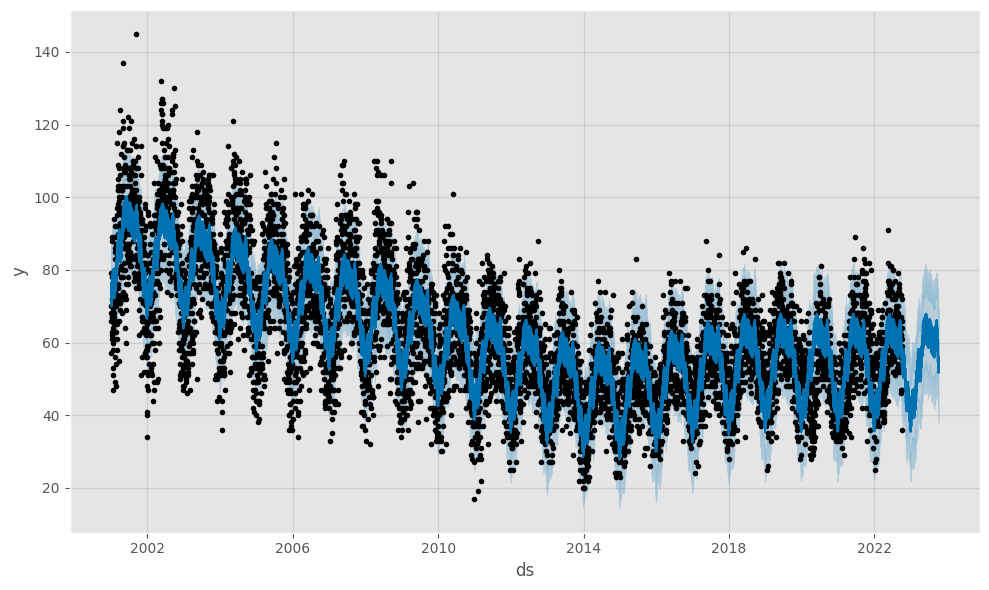

In [22]:
# Fit a prophet model
assaults_prophet_model = Prophet()
assaults_prophet_model.fit(assaults_prophet)

# Make predictions and plot them using model_fit
predictions = assaults_prophet_model.make_future_dataframe(periods=365)
predictions = assaults_prophet_model.predict(predictions)
assaults_prophet_predictions = predictions

assaults_prophet_model.plot(predictions)
plt.show()

In [85]:
# Make the same prediction using a SARIMA

# Fit a SARIMA model using AutoARIMA
model = AutoARIMA(seasonal=True)
model_fit = model.fit(assaults_prophet["y"])


In [86]:

forecast = model_fit.predict_interval(fh=365, X=pd.to_datetime(assaults_prophet.index))
sarima_predictions = pd.DataFrame(forecast)

# Plot the predictions
plt.plot(assaults_prophet.set_index("ds")["y"], color='blue')
plt.plot(sarima_predictions, color='red')
plt.show()

TypeError: X must be either None, or in an sktime compatible format, of scitype Series, Panel or Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynbIf you think X is already in an sktime supported input format, run sktime.datatypes.check_raise(X, mtype) to diagnose the error, where mtype is the string of the type specification you want for X. Possible mtype specification strings are as follows. "For Hierarchical scitype: ['pd_multiindex_hier']. 